<a href="https://colab.research.google.com/github/trngbich/MetaanalysisBiasET/blob/main/PBias_meta_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!pip install joypy

In [2]:
pip install scikit-posthocs

In [179]:
# Import  libraries
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
from plotly import figure_factory as ff
from scipy.stats import linregress
from scipy.stats import ttest_ind, ttest_1samp, f_oneway,kruskal
import scikit_posthocs as sp
import os
plt.style.use('seaborn-v0_8-whitegrid')


!pip install pymannkendall
import pymannkendall as mk


from itertools import combinations
import pandas as pd
import numpy as np
import string


# Read data

**Note**: Make sure Filter is off

In [113]:

# File path
# file_path = "/content/drive/MyDrive/Co-research/P2_meta-analysis/Papers_with_Bias_clean_240324.xlsm"
file_path = "/content/drive/MyDrive/Co-research/P2_meta-analysis/Papers_with_Bias.xlsm"
save_folder = "/content/drive/MyDrive/Co-research/P2_meta-analysis/"
# Read Excel file
df = pd.read_excel(file_path, skiprows=2)

# Filter only rows with numerical values in the "PBIAS" column
df_numeric_pBIAS = df[pd.to_numeric(df['PBIAS (%)'], errors='coerce').notnull()]

In [114]:
df.columns

Index(['Row_ID', 'record_id', 'recorded_by', 'title', 'authors', 'abstract',
       'journal', 'doi', 'year', 'Kawa to update IGBP, DEM and Climate class',
       'double-check outlier (>100%)', 'BIAS (mm/dt)', 'Observed ET (mm/dt)',
       'BIAS (MJ/m2/day)', 'BIAS (W/m2)', 'Observed ET (W/m2)', 'PBIAS (%)',
       'dt', 'Temporal support (dt)', 'Spatial support (m x m)', 'Start date',
       'End date', 'number of observations', 'Growing season? (y/n)',
       'Number of sites (N)', 'Site name in study', 'Conventional site name',
       'IGBP class', 'Latitude (degree North)', 'Longitude (degree East)',
       'Country_code', 'Altitude (m a.s.l)', 'Crop type', 'Climate class',
       'Height of sensor (m)', 'Y_DM', 'X_DM', 'IGBPQGIS', 'IGBP_HYBMAP2000',
       'SRTM_DEM GEE', 'SRTM_DEM 30m', 'KOPPEN _ Beck et al. (2023) QGIS',
       'KOPPEN _ Beck et al. (2023)', 'EB correction', 'use for EB comparison',
       'Tower footprint (m x m)', 'Footprint considered? (y/n)',
       'Spatia

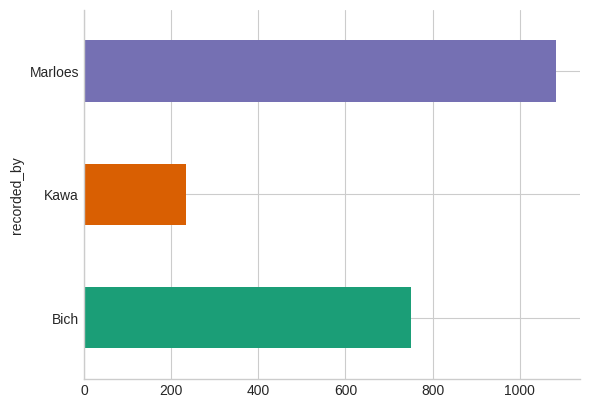

In [115]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('recorded_by').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Dataset description

Question: How PBIAS values are distributed? What is the range of PBIAS?

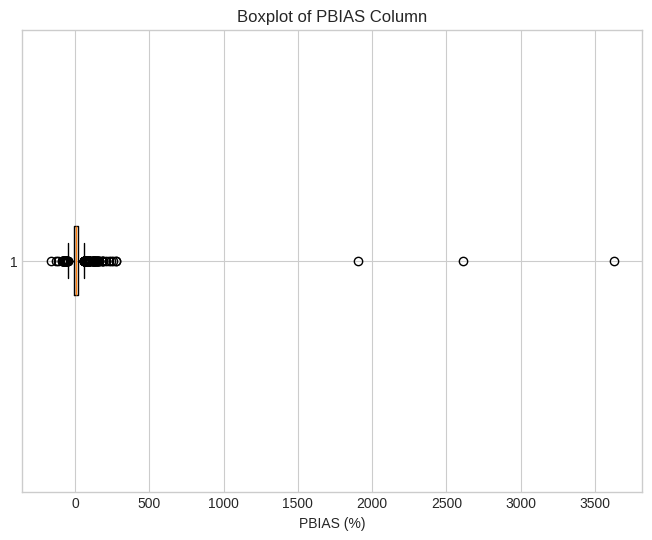

In [116]:
# Plot boxplot of the 'PBIAS' column
plt.figure(figsize=(8, 6))
plt.boxplot(df_numeric_pBIAS['PBIAS (%)'], vert=False)
plt.xlabel('PBIAS (%)')
plt.title('Boxplot of PBIAS Column')
plt.show()

The distribution shows some data point with PBIAS > 1000%. These are outliers due to very small ET values

## Remove outliers

Number of data points: 2063
Number of outliers beyond ±2 standard deviations: 7


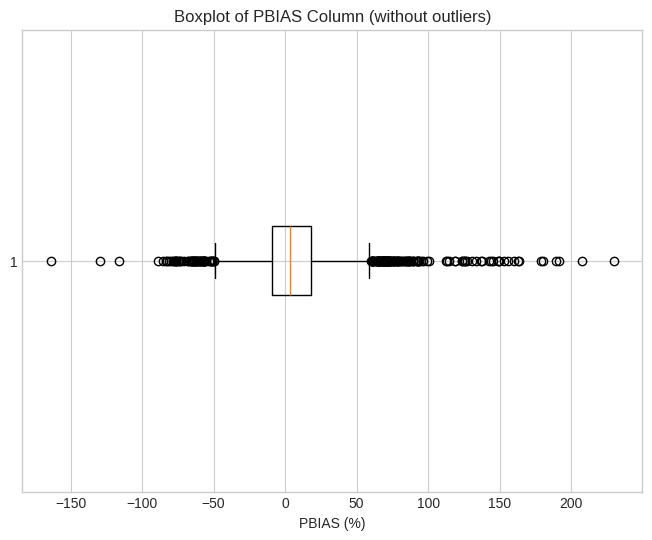

In [117]:
# Define a threshold for outliers (e.g., values beyond ±threshold standard deviations)
threshold = 2

# Calculate the mean and standard deviation of the 'PBIAS' column
mean_pBIAS = df_numeric_pBIAS['PBIAS (%)'].mean()
std_pBIAS = df_numeric_pBIAS['PBIAS (%)'].std()

# Define bounds
lower_bound = mean_pBIAS - threshold * std_pBIAS
upper_bound = mean_pBIAS + threshold * std_pBIAS

# Filtered data (without outliers)
filtered_df = df_numeric_pBIAS[(df_numeric_pBIAS['PBIAS (%)'] >= lower_bound) &
                               (df_numeric_pBIAS['PBIAS (%)'] <= upper_bound)]


# Identify outliers
outliers = df_numeric_pBIAS[(df_numeric_pBIAS['PBIAS (%)'] < lower_bound) |
                            (df_numeric_pBIAS['PBIAS (%)'] > upper_bound)]

# Count outliers
n_total = len(filtered_df)
print(f"Number of data points: {n_total}")

# Number of data
n_outliers = len(outliers)
print(f"Number of outliers beyond ±{threshold} standard deviations: {n_outliers}")

# Plot boxplot of the filtered 'PBIAS' column
plt.figure(figsize=(8, 6))
plt.boxplot(filtered_df['PBIAS (%)'], vert=False)
plt.xlabel('PBIAS (%)')
plt.title('Boxplot of PBIAS Column (without outliers)')
plt.show()

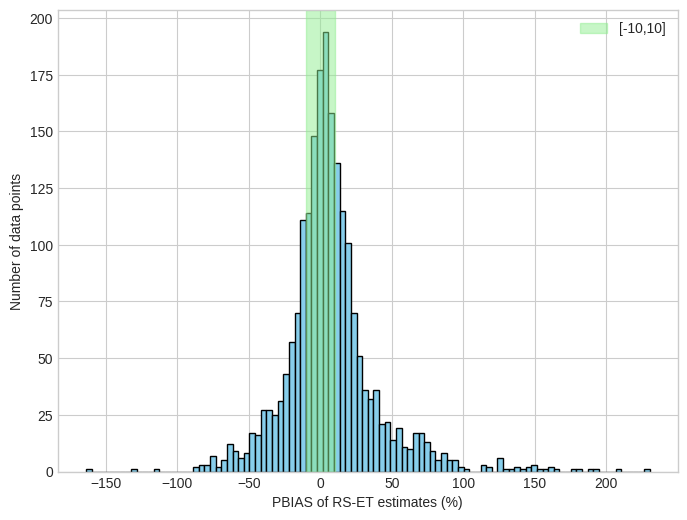

In [118]:
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['PBIAS (%)'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('PBIAS of RS-ET estimates (%)')
plt.ylabel('Number of data points')
# plt.title('Histogram of PBIAS Column')
plt.grid(True)
# Add vertical lines at -10% and 10%
plt.axvspan(-10, 10, color='lightgreen', alpha=0.5,label='[-10,10]')
plt.legend()
plt.show()

In [119]:
# filtered_df['PBIAS (%)'] test if normally distributed

from scipy import stats

# Test for normality using the Shapiro-Wilk test
# Null hypothesis: the data is normally distributed
# Alternative hypothesis: the data is not normally distributed
shapiro_test = stats.shapiro(filtered_df['PBIAS (%)'])

print(f"Shapiro-Wilk Test statistic: {shapiro_test.statistic}")
print(f"Shapiro-Wilk Test p-value: {shapiro_test.pvalue}")

# Interpret the result
alpha = 0.05  # significance level
if shapiro_test.pvalue > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")

Shapiro-Wilk Test statistic: 0.8968325072667713
Shapiro-Wilk Test p-value: 3.836011309623933e-35
The data does not appear to be normally distributed (reject H0)


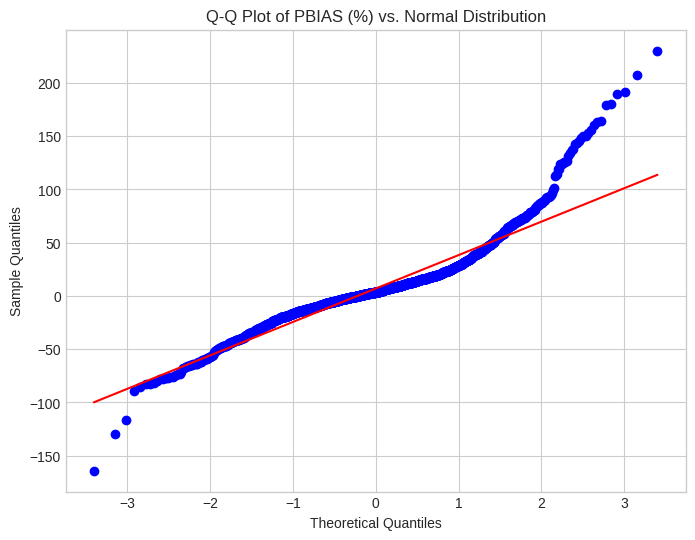

In [120]:
# prompt: plot Q-Q distribution of filtered_df['PBIAS (%)'] and normal distribution with mean and standard deviation of filtered_df['PBIAS (%)']

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
stats.probplot(filtered_df['PBIAS (%)'], dist="norm", plot=plt)
plt.title('Q-Q Plot of PBIAS (%) vs. Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [80]:
# np.random.seed(1)
# x = np.random.randn(1000)
hist_data = [filtered_df['PBIAS (%)'].astype(float)]
group_labels = ['PBIAS (%)'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

## Plot probrability distribution and statistics

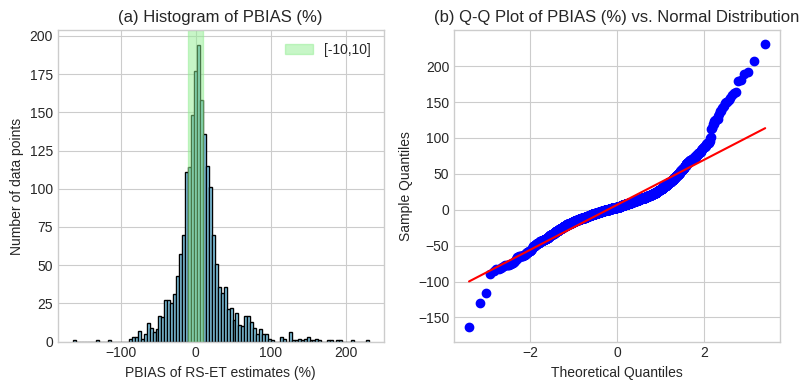

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Subplot (a): Histogram
axes[0].hist(filtered_df['PBIAS (%)'], bins=100, color='skyblue', edgecolor='black')
axes[0].set_xlabel('PBIAS of RS-ET estimates (%)')
axes[0].set_ylabel('Number of data points')
axes[0].grid(True)
axes[0].axvspan(-10, 10, color='lightgreen', alpha=0.5, label='[-10,10]')
axes[0].legend()
axes[0].set_title('(a) Histogram of PBIAS (%)')

# Subplot (b): Q-Q plot
stats.probplot(filtered_df['PBIAS (%)'], dist="norm", plot=axes[1])
axes[1].set_title('(b) Q-Q Plot of PBIAS (%) vs. Normal Distribution')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(save_folder,'1_pbias_distribution.png'), bbox_inches='tight')
plt.show()



In [122]:
# Calculate descriptive statistics
pbias_stats = filtered_df['PBIAS (%)'].describe()

# Print the descriptive statistics
print(pbias_stats)

count    2063.000000
mean        6.873967
std        33.146562
min      -164.000000
25%        -9.106773
50%         3.460000
75%        18.000000
max       230.279898
Name: PBIAS (%), dtype: float64


## PBIAS distribution with ET

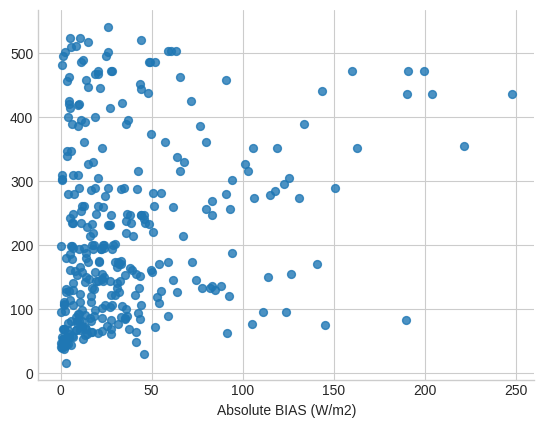

In [123]:
plt.scatter(filtered_df['BIAS (W/m2)'].abs(), filtered_df['Observed ET (W/m2)'], s=32, alpha=.8)
plt.xlabel('Absolute BIAS (W/m2)') # Update the x-axis label
plt.gca().spines[['top', 'right',]].set_visible(False)

## Test if average relative PBIAS is <10%

In [125]:
# Perform one-sample t-test
t_statistic, p_value = ttest_1samp(filtered_df['PBIAS (%)'].abs(), 10)

# Print the results
print("Mean Absolute PBIAS:", mean_absolute_pBIAS)
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Check for significance
if p_value < 0.05:
    print("The mean absolute PBIAS is significantly less than 10% (p < 0.05)")
else:
    print("The mean absolute PBIAS is not significantly less than 10% (p >= 0.05)")

Mean Absolute PBIAS: 22.046550928830147
T-Statistic: 21.303195338833405
P-Value: 3.512158579847452e-91
The mean absolute PBIAS is significantly less than 10% (p < 0.05)


# Date range

Question: How PBIAS changes over time?

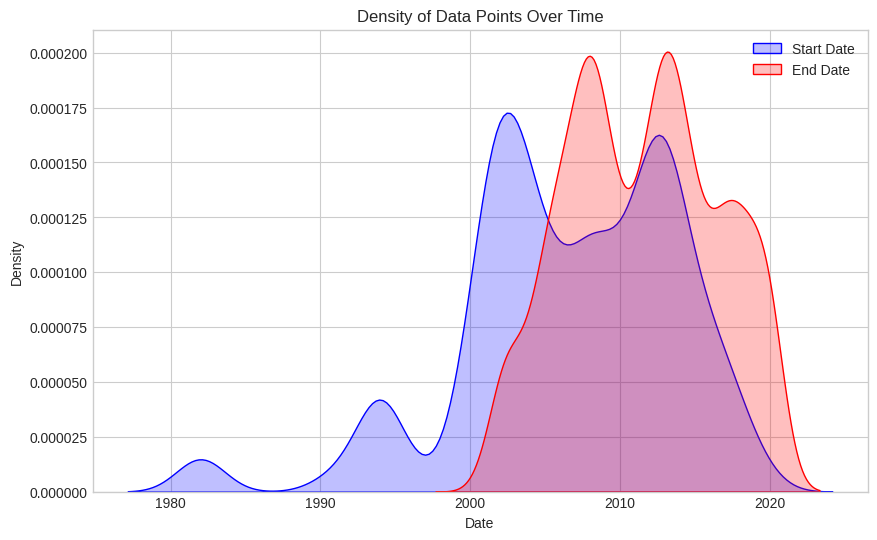

In [126]:
df_=filtered_df
# Convert "YYYY-DOY" format to datetime
df_['Start date'] = pd.to_datetime(df_['Start date'], format='%Y-%j')
df_['End date'] = pd.to_datetime(df_['End date'], format='%Y-%j')

# Create a new DataFrame with individual dates
dates_df = pd.DataFrame({
    'date': pd.date_range(df_['Start date'].min(), df_['End date'].max())
})

# Calculate the density of data points over time
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_['Start date'], color='blue', fill=True, label='Start Date')
sns.kdeplot(data=df_['End date'], color='red', fill=True, label='End Date')
plt.xlabel('Date')
plt.ylabel('Density')
plt.title('Density of Data Points Over Time')
plt.legend()
plt.show()

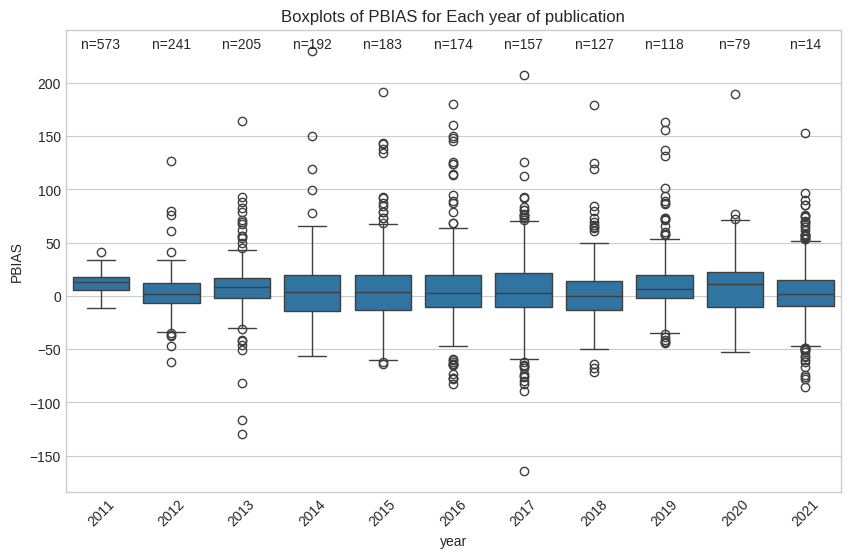

In [127]:
df_ = filtered_df
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['year'].value_counts().reset_index()
group_counts.columns = ['year', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('year')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each year of publication')
plt.xticks(rotation=45)
plt.show()

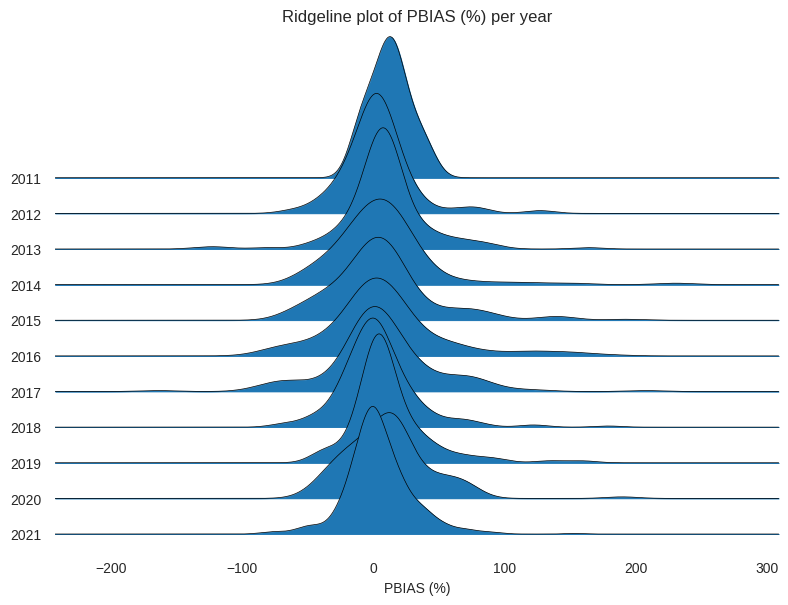

In [128]:
# prompt: Using dataframe df_year: plot ridgeline plot (also known as a joyplot) of PBIAS (%) per year. do not use altair

import joypy
import matplotlib.pyplot as plt

# Create the ridgeline plot using joypy
fig, axes = joypy.joyplot(
    df_year,
    by="year",
    column="PBIAS (%)",
    figsize=(8, 6),
    title="Ridgeline plot of PBIAS (%) per year",
    linewidth=0.5,
    overlap=2
)

# Add labels to the plot
plt.xlabel("PBIAS (%)")
plt.ylabel("Year")

# Display the plot
plt.show()

## Plot distribution by year

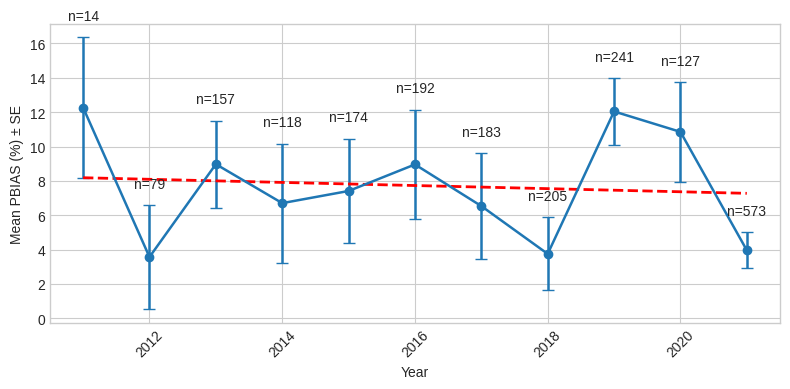

In [129]:
df_ = filtered_df.copy()

# ---------- summary statistics ----------
summary = (df_
           .groupby('year', as_index=False)['PBIAS (%)']
           .agg(mean='mean', std='std', n='count'))
summary['se'] = summary['std'] / np.sqrt(summary['n'])   # standard error

# ---------- line chart with error bars ----------
plt.figure(figsize=(8, 4))
plt.errorbar(
    summary['year'],
    summary['mean'],
    yerr=summary['se'],
    fmt='-o',           # line + round markers
    capsize=4,          # length of error-bar caps
    linewidth=1.8,
    markersize=6
)

# annotate sample sizes
for x, y, s in zip(summary['year'], summary['mean'], summary['n']):
    plt.text(x, y + summary.loc[summary['year'] == x, 'se'].iat[0] + 1,
             f'n={s}', ha='center')


# ---------- fit linear regression line ----------
coeffs = np.polyfit(summary['year'], summary['mean'], deg=1)  # linear fit: y = mx + b
trendline = np.poly1d(coeffs)
x_vals = np.linspace(summary['year'].min(), summary['year'].max(), 100)
y_vals = trendline(x_vals)
# ---------- add regression trend line ----------
plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2, label=f'Regression trend')


plt.xlabel('Year')
plt.ylabel('Mean PBIAS (%) ± SE')
# plt.title('Mean PBIAS by Year with Standard Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder,'2_pbias_by_year.png'), bbox_inches='tight')
plt.show()


## Test if there is significant trend in median and mean PBIAS through out the years

In [130]:
# Group data by year and calculate median and mean PBIAS
yearly_stats = filtered_df.groupby('year')['PBIAS (%)'].agg(['median', 'mean']).reset_index()

# create a list of PBIAS values for each year
yearly_pbias = [filtered_df['PBIAS (%)'][filtered_df['year'] == year] for year in filtered_df['year'].unique()]

# Perform the Kruskal-Wallis test
h_statistic, p_value_kruskal = kruskal(*yearly_pbias)

print("\nKruskal-Wallis Test for Median PBIAS Trend:")
print("H-Statistic:", h_statistic)
print("P-Value:", p_value_kruskal)

if p_value_kruskal < 0.01:
    print("There is a significant trend in median PBIAS over the years (p < 0.05)")
else:
    print("There is no significant trend in median PBIAS over the years (p >= 0.05)")


# Perform linear regression on yearly mean PBIAS
slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = linregress(yearly_stats['year'], yearly_stats['mean'])

print("\nLinear Regression for Mean PBIAS Trend:")
print("Slope:", slope_mean)
print("P-Value:", p_value_mean)

if p_value_mean < 0.01:
    print("There is a significant linear trend in mean PBIAS over the years (p < 0.05)")
    if slope_mean > 0:
        print("The trend is increasing.")
    else:
        print("The trend is decreasing.")
else:
    print("There is no significant linear trend in mean PBIAS over the years (p >= 0.05)")

# perform linear regression on yearly median PBIAS for a similar trend analysis
slope_median, intercept_median, r_value_median, p_value_median, std_err_median = linregress(yearly_stats['year'], yearly_stats['median'])

print("\nLinear Regression for Median PBIAS Trend:")
print("Slope:", slope_median)
print("P-Value:", p_value_median)

if p_value_median < 0.01:
    print("There is a significant linear trend in median PBIAS over the years (p < 0.05)")
    if slope_median > 0:
        print("The trend is increasing.")
    else:
        print("The trend is decreasing.")
else:
    print("There is no significant linear trend in median PBIAS over the years (p >= 0.05)")



Kruskal-Wallis Test for Median PBIAS Trend:
H-Statistic: 27.786874112612434
P-Value: 0.0019526159374627708
There is a significant trend in median PBIAS over the years (p < 0.05)

Linear Regression for Mean PBIAS Trend:
Slope: -0.09070842967770974
P-Value: 0.7827439500069349
There is no significant linear trend in mean PBIAS over the years (p >= 0.05)

Linear Regression for Median PBIAS Trend:
Slope: -0.3157346806454545
P-Value: 0.4440771068126489
There is no significant linear trend in median PBIAS over the years (p >= 0.05)


 Kruskal-Wallis test is a non-parametric test used to compare the medians of two or more independent groups. It is used to see if there's a significant difference in the median of the variable across different time periods. The test assumes independent random samples, the distribution shapes are similar across groups (though their medians can differ).

Linear regression is a parametric test that assumes a linear relationship between the variable you're testing for a trend (e.g., PBIAS) and time (e.g., year). It's appropriate when the data is approximately normally distributed and the relationship appears linear. It tests if the slope of the line is significantly different from zero. The test assumes normality of residuals, independence of observations, homoscedasticity (equal variances of residuals), linearity.

Mann-Kendall is a non-parametric test, meaning it doesn't assume normality or linearity. It's suitable for detecting monotonic trends (either consistently increasing or decreasing) in time series data. It's less sensitive to outliers than parametric tests like linear regression. The test also assumes data are independent, and the variance of the data is constant over time (though variations exist to handle this).

In [131]:
# Group data by year and calculate median and mean PBIAS
yearly_stats = df_.groupby('year')['PBIAS (%)'].agg(['median', 'mean']).reset_index()

# Perform Mann-Kendall test for median PBIAS trend
mk_median = mk.original_test(yearly_stats['median'])

print("\nMann-Kendall Test for Median PBIAS Trend:")
print(f"Mann-Kendall Test Results: {mk_median}")

# Perform Mann-Kendall test for mean PBIAS trend
mk_mean = mk.original_test(yearly_stats['mean'])

print("\nMann-Kendall Test for Mean PBIAS Trend:")
print(f"Mann-Kendall Test Results: {mk_mean}")



Mann-Kendall Test for Median PBIAS Trend:
Mann-Kendall Test Results: Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.27575784782750934), z=np.float64(-1.0898985218261321), Tau=np.float64(-0.2727272727272727), s=np.float64(-15.0), var_s=165.0, slope=np.float64(-0.36666666666666653), intercept=np.float64(5.763498055333333))

Mann-Kendall Test for Mean PBIAS Trend:
Mann-Kendall Test Results: Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.7554968749288828), z=np.float64(-0.3113995776646092), Tau=np.float64(-0.09090909090909091), s=np.float64(-5.0), var_s=165.0, slope=np.float64(-0.05703983692746414), intercept=np.float64(7.698409400560884))


In [132]:

# Group data by year and calculate median and mean PBIAS
yearly_stats = df_.groupby('year')['PBIAS (%)'].agg(['min', 'max']).reset_index()

# Perform Mann-Kendall test for median PBIAS trend
mk_median = mk.original_test(yearly_stats['min'])

print("\nMann-Kendall Test for Min PBIAS Trend:")
print(f"Mann-Kendall Test Results: {mk_median}")

# Perform Mann-Kendall test for mean PBIAS trend
mk_mean = mk.original_test(yearly_stats['max'])

print("\nMann-Kendall Test for Max PBIAS Trend:")
print(f"Mann-Kendall Test Results: {mk_mean}")



Mann-Kendall Test for Min PBIAS Trend:
Mann-Kendall Test Results: Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.5334165134726945), z=np.float64(-0.6227991553292184), Tau=np.float64(-0.16363636363636364), s=np.float64(-9.0), var_s=165.0, slope=np.float64(-2.603921568888889), intercept=np.float64(-51.28039215555555))

Mann-Kendall Test for Max PBIAS Trend:
Mann-Kendall Test Results: Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.7554968749288828), z=np.float64(0.3113995776646092), Tau=np.float64(0.09090909090909091), s=np.float64(5.0), var_s=165.0, slope=np.float64(3.030000000000001), intercept=np.float64(163.85))


In [133]:
mk_mean

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.7554968749288828), z=np.float64(0.3113995776646092), Tau=np.float64(0.09090909090909091), s=np.float64(5.0), var_s=165.0, slope=np.float64(3.030000000000001), intercept=np.float64(163.85))

# Validation Duration

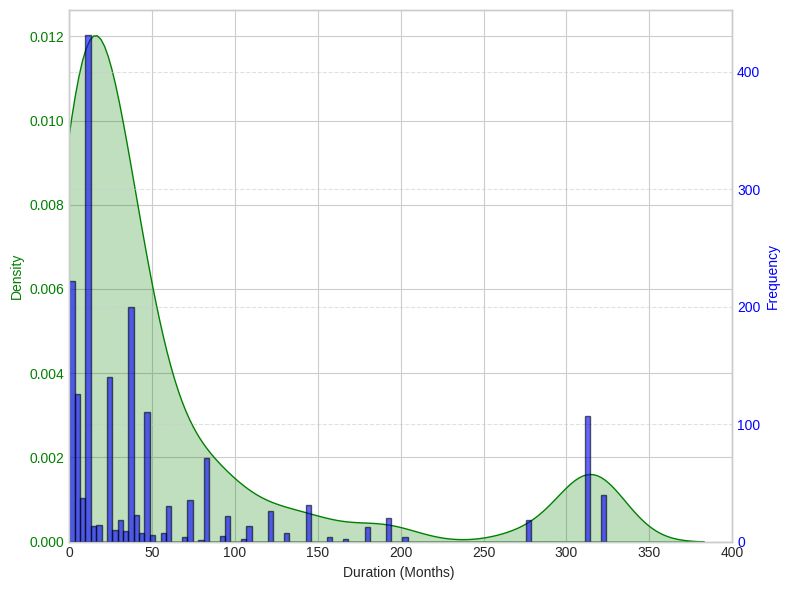

In [144]:
# Calculate the duration between start date and end date
df_ = filtered_df.copy()
df_['duration'] = (df_['End date'] - df_['Start date']).dt.days
df_['duration_months'] = df_['duration'] / 30.4375

# Create a figure and a primary axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the KDE plot on the primary axes (ax1)
sns.kdeplot(data=df_['duration_months'], color='green', fill=True, ax=ax1)
ax1.set_xlabel('Duration (Months) ')
ax1.set_ylabel('Density', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xlim(0,400)

# Create a secondary axes that shares the same x-axis
ax2 = ax1.twinx()

# Plot the histogram on the secondary axes (ax2)
ax2.hist(df_['duration_months'], bins=100, color='blue', edgecolor='black', alpha=0.6)
ax2.set_ylabel('Frequency', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# plt.title('Density and Frequency of Durations between Start Date and End Date')
plt.grid(True, axis='y', linestyle='--', alpha=0.6) # Add grid for frequency
fig.tight_layout() # Adjust layout
plt.show()

In [138]:
negative_duration_rows = df_[df_['duration'] < 0]

# Display the rows where duration is negative
print(negative_duration_rows['record_id'])

Series([], Name: record_id, dtype: int64)


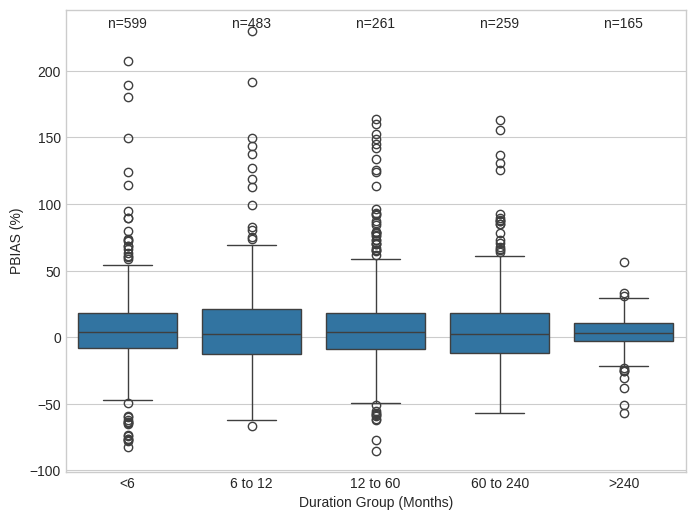

In [148]:
# Group data into 3 groups based on duration in months
df_['duration_group'] = pd.cut(df_['duration_months'], bins=[0,6, 12, 60, 240, float('inf')], labels=['<6','6 to 12','12 to 60', '60 to 240', '>240'])

# Plot boxplot of "pbias (%)" for each group
plt.figure(figsize=(8, 6))
sns.boxplot(x='duration_group', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['duration_group'].value_counts().reset_index()
group_counts.columns = ['duration_group', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('Duration Group (Months)')
plt.ylabel('PBIAS (%)')
# plt.title('Boxplot of PBIAS (%) for Duration Groups')
plt.savefig(os.path.join(save_folder,'3_pbias_by_duration.png'), bbox_inches='tight')
plt.show()

no significant difference between groups 0-50, 50-250, >250...
but significant difference between groups 0-12, 12-60, 60-240, >240

In [147]:
# Perform one-way ANOVA
anova_result = f_oneway(df_[df_['duration_group'] == '<12']['PBIAS (%)'],
                        df_[df_['duration_group'] == '12 to 60']['PBIAS (%)'],
                        df_[df_['duration_group'] == '60 to 240']['PBIAS (%)'],
                        df_[df_['duration_group'] == '>240']['PBIAS (%)'])

# Print the ANOVA result
print("ANOVA F-Statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("There is a significant difference between the groups (p < 0.05)")
else:
    print("There is no significant difference between the groups (p >= 0.05)")

ANOVA F-Statistic: nan
ANOVA p-value: nan
There is no significant difference between the groups (p >= 0.05)


/tmp/ipython-input-147-2124085278.py:2: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



In [40]:
# Perform Kruskal-Wallis H-test
kruskal_result = kruskal(df_[df_['duration_group'] == '<12']['PBIAS (%)'],
                        df_[df_['duration_group'] == '12 to 60']['PBIAS (%)'],
                        df_[df_['duration_group'] == '60 to 240']['PBIAS (%)'],
                        df_[df_['duration_group'] == '>240']['PBIAS (%)'])


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

Kruskal-Wallis H-Statistic: nan
Kruskal-Wallis p-value: nan
There is no significant difference in the distribution of the groups (p >= 0.05)


/tmp/ipython-input-40-2004301505.py:2: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



# Model types

In [149]:
# Define a list of values to filter
values_to_filter = ['1SEB', '2SEB', 'PM','PT', 'Empirical' , 'Factor', 'Ts-VI','Others'] # valid Model types

# Filter rows with values in the "model types" column
df_models = filtered_df[filtered_df['Model Type'].isin(values_to_filter)]

In [150]:
df_models.to_csv('PBIAS_by_model_Type.csv')

## Boxplots

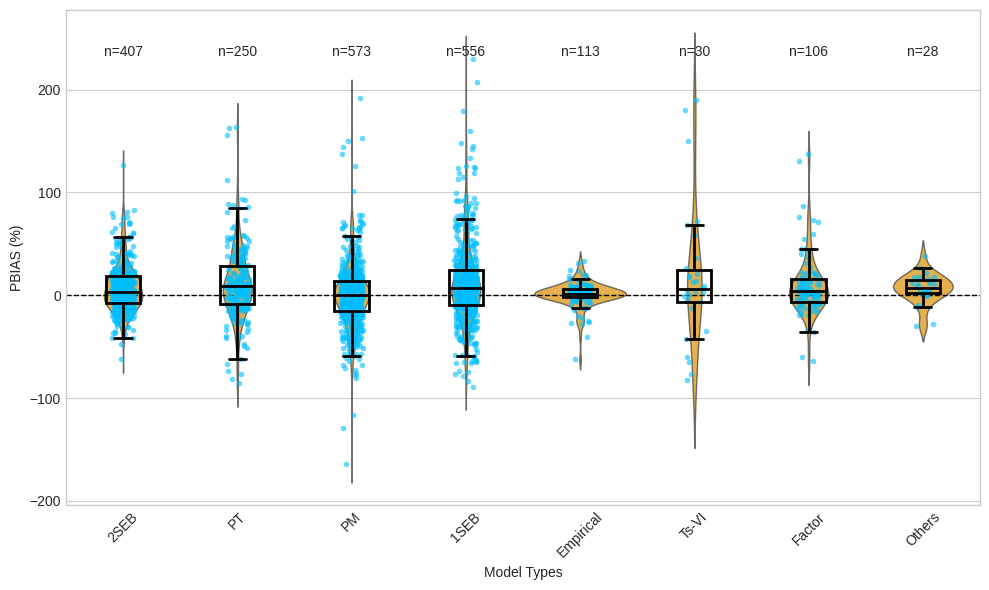

In [214]:
df_ = df_models

# Set up the plot
plt.figure(figsize=(10, 6))



# Then plot the strip plot on top
sns.stripplot(
    x='Model Type', y='PBIAS (%)', data=df_,
    color='deepskyblue', jitter=True, size=4, alpha=0.6
)

# Plot violin plot first (as smooth KDE background, with no internal box)
sns.violinplot(
    x='Model Type', y='PBIAS (%)', data=df_,
    inner=None, linewidth=1, color='orange', alpha=0.8
)
# Overlay boxplot (no fill, sharp outline)
sns.boxplot(
    x='Model Type', y='PBIAS (%)', data=df_,
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Annotate group sizes
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
model_order = df_['Model Type'].unique()

for i, model_type in enumerate(model_order):
    count = group_counts[group_counts['Model Type'] == model_type]['count'].values[0]
    plt.text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')

# Labels and title
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Model Types')
plt.ylabel('PBIAS (%)')
# plt.yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
# plt.title('Violin + Strip + Outline Boxplot of PBIAS for Each Model Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

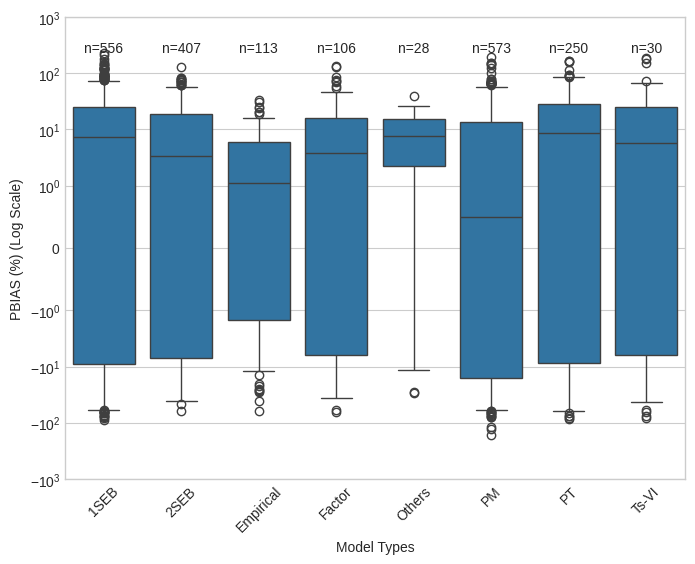

In [212]:
df_ = df_models
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(8, 6))
# Define the desired order for the x-axis
model_order = ['1SEB', '2SEB', 'Empirical', 'Factor', 'Others', 'PM', 'PT', 'Ts-VI']
sns.boxplot(x='Model Type', y='PBIAS (%)', data=df_, order=model_order)

# Annotate the plot with the count of data points for each group
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
# Ensure group_counts is in the same order as model_order for correct annotation placement
group_counts = group_counts.set_index('Model Type').loc[model_order].reset_index()


for index, row in group_counts.iterrows():
    # Adjust text placement slightly if needed based on the log scale
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')


plt.xlabel('Model Types')
plt.ylabel('PBIAS (%) (Log Scale)') # Update y-axis label
# plt.title('Boxplots of PBIAS (%) for Each Model Type (Log Scale)') # Update title
plt.xticks(rotation=45)
plt.yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
plt.ylim(-1000,1000)
plt.savefig(os.path.join(save_folder,'4_pbias_by_model_type.png'), bbox_inches='tight')
plt.show()

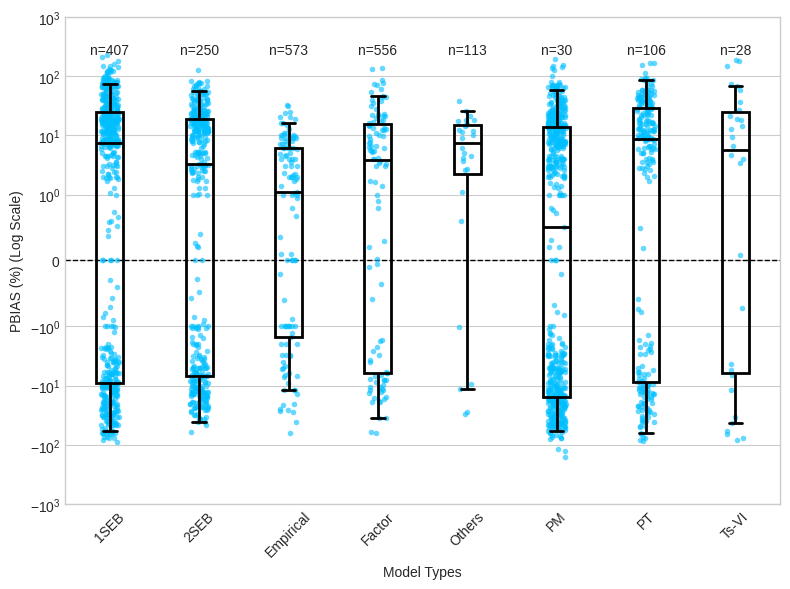

In [217]:


df_ = df_models

# Set up the plot
plt.figure(figsize=(8, 6))
model_order = ['1SEB', '2SEB', 'Empirical', 'Factor', 'Others', 'PM', 'PT', 'Ts-VI']
# Plot strip plot first (so it's underneath)
sns.stripplot(x='Model Type', y='PBIAS (%)', data=df_,
              color='deepskyblue', jitter=True, size=4, alpha=0.6,order=model_order)

# Overlay boxplot with no fill and thicker, brighter outline
sns.boxplot(
    x='Model Type', y='PBIAS (%)', data=df_,
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Annotate group sizes
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
model_order = df_['Model Type'].unique()

for i, model_type in enumerate(model_order):
    count = group_counts[group_counts['Model Type'] == model_type]['count'].values[0]
    plt.text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')

# Labels and title
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Model Types')
plt.ylabel('PBIAS (%) (Log Scale)') # Update y-axis label
plt.yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
plt.ylim(-1000,1000)
# plt.title('Strip Plot + Outline Boxplot of PBIAS for Each Model Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder,'4_pbias_by_model_type.png'), bbox_inches='tight')
plt.show()


In [154]:
df_model_types =  df_[['Model Type','PBIAS (%)']]
df_model_types

,Model Type,PBIAS (%)
0,2SEB,13.100000
1,2SEB,8.000000
2,2SEB,19.400000
3,2SEB,14.600000
4,2SEB,8.200000
...,...,...
2065,2SEB,-3.200000
2066,2SEB,0.400000
2067,2SEB,5.200001
2068,2SEB,80.999988


## Sample size

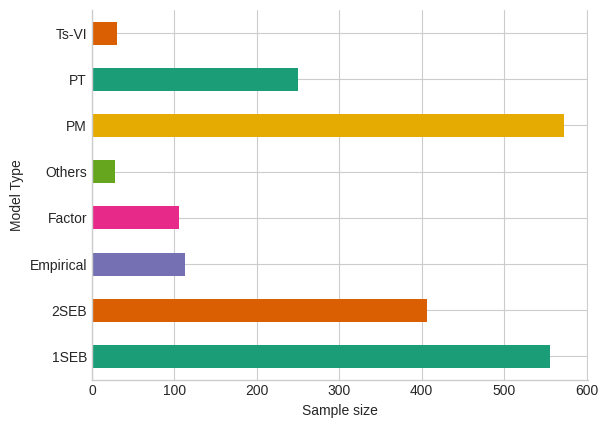

In [157]:
df_model_types.groupby('Model Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.xlabel('Sample size')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Descriptive statistics

In [192]:
# Group the data by 'Model Type' and calculate descriptive statistics for 'PBIAS (%)'
df_model_types_stats= df_model_types.groupby('Model Type')['PBIAS (%)'].describe()
df_model_types_stats

,count,mean,std,min,25%,50%,75%,max
Model Type,,,,,,,,
1SEB,556.0,11.675331,39.340809,-89.000000,-9.000000,7.314921,24.563953,230.279898
2SEB,407.0,7.453964,23.219288,-61.764706,-7.035354,3.300000,18.840336,127.000000
Empirical,113.0,0.960544,12.462327,-62.409639,-1.500000,1.100000,6.000000,33.000000
Factor,106.0,9.311970,29.226439,-64.300000,-6.139959,3.814540,15.746875,137.000000
Others,28.0,6.767544,14.399628,-30.000000,2.225000,7.500000,15.200000,38.600000
PM,573.0,0.054135,32.290089,-164.000000,-15.753425,0.500000,13.770000,191.601743
PT,250.0,11.339265,34.898677,-85.200000,-8.684091,8.623937,28.904155,163.850000
Ts-VI,30.0,16.827008,65.169103,-82.583708,-6.269551,5.680000,25.036191,189.600000


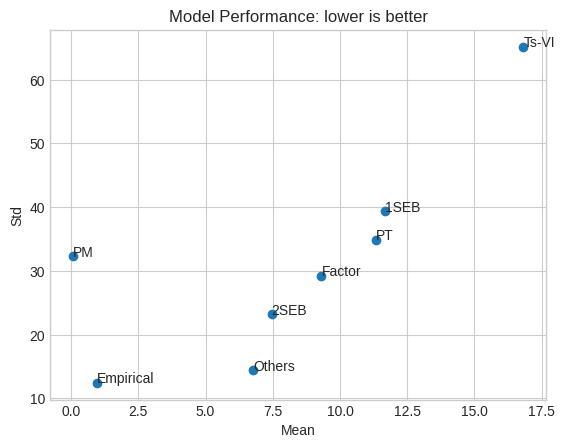

In [193]:
ms = df_model_types_stats['mean']
ss = df_model_types_stats['std']
labels = df_model_types_stats.index

plt.scatter(ms, ss)
for x,y,label in zip(ms,ss,labels):
    plt.text(x, y, label)
plt.xlabel("Mean")
plt.ylabel("Std")
plt.title("Model Performance: lower is better")
plt.show()


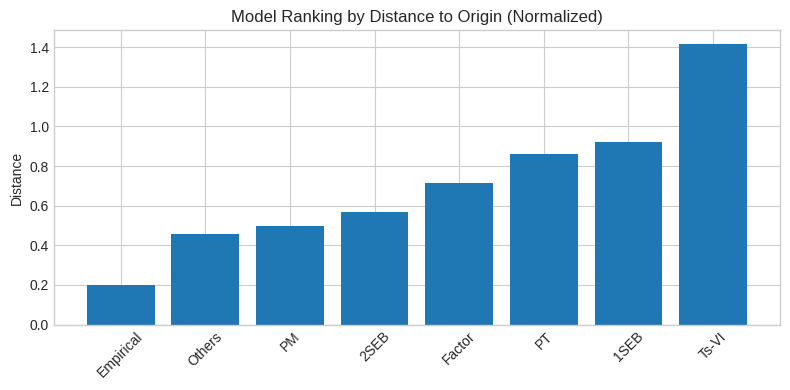

In [199]:
# Normalize mean and std
df_model_types_stats['Mean_norm'] = df_model_types_stats['mean'] / df_model_types_stats['mean'].max()
df_model_types_stats['Std_norm'] = df_model_types_stats['std'] / df_model_types_stats['std'].max()

# Compute Euclidean distance
df_model_types_stats['Distance'] = np.sqrt(df_model_types_stats['Mean_norm']**2 + df_model_types_stats['Std_norm']**2)

# Sort by best (lowest distance)
df_sorted = df_model_types_stats.sort_values('Distance')

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(df_sorted.index, df_sorted['Distance'])
plt.title('Model Ranking by Distance to Origin (Normalized)')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Ranking
df['Mean_rank'] = df['Mean'].rank()
df['Std_rank'] = df['Std'].rank()
df['RankSum'] = df['Mean_rank'] + df['Std_rank']

# Sort by RankSum
df_sorted = df.sort_values('RankSum')

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(df_sorted['Model'], df_sorted['RankSum'])
plt.title('Model Ranking by Sum of Ranks (Mean + Std)')
plt.ylabel('Rank Sum')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Pareto front calculation
def is_pareto_efficient(df):
    is_efficient = np.ones(df.shape[0], dtype=bool)
    for i, (m, s) in enumerate(zip(df['Mean'], df['Std'])):
        if is_efficient[i]:
            is_efficient[is_efficient] = ~(
                (df['Mean'][is_efficient] > m) &
                (df['Std'][is_efficient] > s)
            )
            is_efficient[i] = True
    return is_efficient

df['Pareto'] = is_pareto_efficient(df)

# Plot
colors = ['green' if x else 'gray' for x in df['Pareto']]
plt.figure(figsize=(6,6))
plt.scatter(df['Mean'], df['Std'], c=colors)
for i in range(len(df)):
    plt.text(df['Mean'][i], df['Std'][i], df['Model'][i], fontsize=9)
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('Pareto Front (Green = Pareto-Optimal)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Normal distribution test

In [162]:

from scipy import stats
import pandas as pd

# Group data by 'Model Type'
grouped_data = df_model_types.groupby('Model Type')

# Iterate over each group
results = {}
for name, group in grouped_data:
    # Normalize the 'PBIAS (%)' data for the current group by subtracting the mean
    normalized_data = group['PBIAS (%)'] - group['PBIAS (%)'].mean()

    # Perform the Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(group['PBIAS (%)'])
    # Store the results (S-W statistic and p-value)
    results[name] = {'SW Statistic': statistic, 'P-value': p_value}

# Print the results for each 'Model Type'
for model_type, result in results.items():
    print(f"Model Type: {model_type}")
    print(f"  Shapiro-Wilk Statistic: {result['SW Statistic']:.4f}")
    print(f"  P-value: {result['P-value']:.4f}")
    # Interpret the p-value (common alpha level is 0.05)
    if result['P-value'] < 0.05:
        print("  Interpretation: The distribution is likely not normal (reject null hypothesis).")
    else:
        print("  Interpretation: The distribution is likely normal (fail to reject null hypothesis).")
    print("-" * 30)

Model Type: 1SEB
  Shapiro-Wilk Statistic: 0.9114
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: 2SEB
  Shapiro-Wilk Statistic: 0.9475
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Empirical
  Shapiro-Wilk Statistic: 0.8593
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Factor
  Shapiro-Wilk Statistic: 0.8341
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Others
  Shapiro-Wilk Statistic: 0.9334
  P-value: 0.0751
  Interpretation: The distribution is likely normal (fail to reject null hypothesis).
------------------------------
Model Type: PM
  Shapiro-Wilk Statistic: 0.9087
  P-value: 0.0000
  Interpretation

In [163]:
# Using dataframe df_model_types: test whether the 'PBIAS (%)' for each 'Model Type' is normally distributed (e.g., using Kolomogorov– Smirnov test). Normalize distribution to mean value before doing the test

from scipy import stats
import pandas as pd

# Group data by 'Model Type'
grouped_data = df_model_types.groupby('Model Type')

# Iterate over each group
results = {}
for name, group in grouped_data:
    # Normalize the 'PBIAS (%)' data for the current group by subtracting the mean
    normalized_data = group['PBIAS (%)'] - group['PBIAS (%)'].mean()

    # Perform the Kolmogorov-Smirnov test for normality on the normalized data
    ks_statistic, p_value = stats.kstest(normalized_data, 'norm')

    # Store the results (KS statistic and p-value)
    results[name] = {'KS Statistic': ks_statistic, 'P-value': p_value}

# Print the results for each 'Model Type'
for model_type, result in results.items():
    print(f"Model Type: {model_type}")
    print(f"  Kolmogorov-Smirnov Statistic: {result['KS Statistic']:.4f}")
    print(f"  P-value: {result['P-value']:.4f}")
    # Interpret the p-value (common alpha level is 0.05)
    if result['P-value'] < 0.05:
        print("  Interpretation: The distribution is likely not normal (reject null hypothesis).")
    else:
        print("  Interpretation: The distribution is likely normal (fail to reject null hypothesis).")
    print("-" * 30)

Model Type: 1SEB
  Kolmogorov-Smirnov Statistic: 0.5473
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: 2SEB
  Kolmogorov-Smirnov Statistic: 0.5288
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Empirical
  Kolmogorov-Smirnov Statistic: 0.3864
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Factor
  Kolmogorov-Smirnov Statistic: 0.5994
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: Others
  Kolmogorov-Smirnov Statistic: 0.4835
  P-value: 0.0000
  Interpretation: The distribution is likely not normal (reject null hypothesis).
------------------------------
Model Type: PM
  Kolmogorov-Smirnov Statistic: 0.4480
  

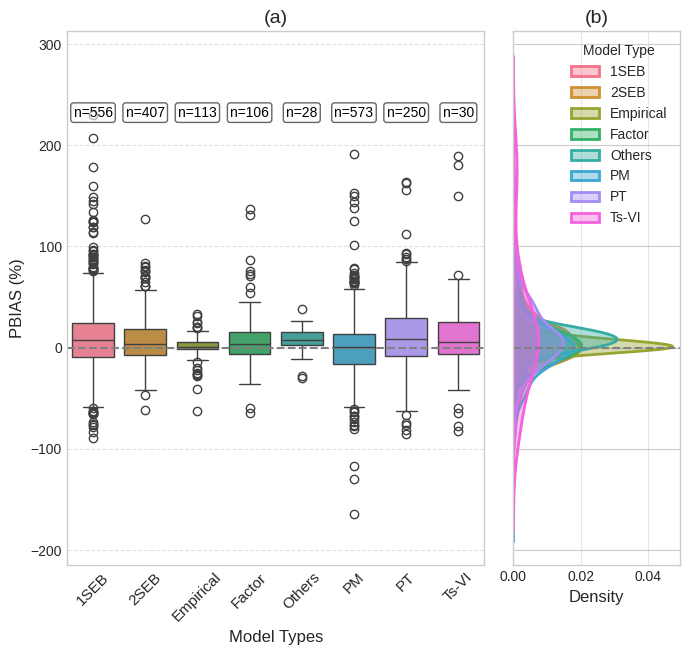

In [205]:
# Get a sorted list of unique model types for consistent ordering and coloring
model_types = sorted(df_['Model Type'].unique())

# Define a color palette as a dictionary to map each model type to a specific color
colors = sns.color_palette('husl', len(model_types))
color_palette = dict(zip(model_types, colors))


# --- MODIFICATION HERE ---
# To make the right panel narrower, we use gridspec_kw to set the width ratios.
# '[2.5, 1]' makes the left panel 2.5 times wider than the right panel.
# The overall figsize is also adjusted for a better presentation.
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(10, 7),
    sharey=True,
    gridspec_kw={'width_ratios': [2.5, 1]}
)

# fig.suptitle('Comparison of PBIAS (%) Distribution by Model Type', fontsize=16, y=0.98)


# --- Plot 1: Boxplots (left subplot) ---'
# Plot strip plot first (so it's underneath)
# sns.stripplot(x='Model Type', y='PBIAS (%)', data=df_, ax=ax1,
#               palette=color_palette, order=model_types, jitter=True, size=4, alpha=0.6)
sns.boxplot(x='Model Type', y='PBIAS (%)', data=df_, ax=ax1, palette=color_palette, order=model_types)
ax1.axhline(0, color='grey', linestyle='--', linewidth=1.5)

# Annotate with data point counts
group_counts = df_['Model Type'].value_counts()
plot_ymin, plot_ymax = ax1.get_ylim()
text_y_pos = plot_ymax - (plot_ymax - plot_ymin) * 0.05

for i, model_type in enumerate(model_types):
    count = group_counts[model_type]
    ax1.text(i, text_y_pos, f'n={count}', ha='center', color='black', bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2'))

ax1.set_xlabel('Model Types', fontsize=12)
ax1.set_ylabel('PBIAS (%)', fontsize=12)
ax1.set_title('(a)', fontsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=11)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)


# --- Plot 2: Rotated KDE Plots (right subplot) ---
for model_type in model_types:
    model_data = df_[df_['Model Type'] == model_type]['PBIAS (%)'].dropna()
    sns.kdeplot(
        y=model_data,
        label=model_type,
        color=color_palette[model_type],
        linewidth=2,
        fill=True,
        alpha=0.4,
        ax=ax2
    )

ax2.axhline(0, color='grey', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Density', fontsize=12)
ax2.set_title('(b)', fontsize=14)
ax2.legend(title='Model Type')
ax2.grid(True, axis='x', alpha=0.5)

# plt.yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
# --- Final adjustments and display ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Test difference between the model types

In [166]:
# Perform one-way ANOVA
anova_result = f_oneway(df_[df_['Model Type'] == '2SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == '1SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PT']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PM']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Empirical']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Factor']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Others']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Ts-VI']['PBIAS (%)'],
                        )

# Print the ANOVA result
print("ANOVA F-Statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("There is a significant difference between the groups (p < 0.05)")
else:
    print("There is no significant difference between the groups (p >= 0.05)")

ANOVA F-Statistic: 6.916048948384149
ANOVA p-value: 3.709524823071777e-08
There is a significant difference between the groups (p < 0.05)


In [167]:
# Perform Kruskal-Wallis H-test
kruskal_result = kruskal(df_[df_['Model Type'] == '2SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == '1SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PT']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PM']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Empirical']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Factor']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Others']['PBIAS (%)'],
                         df_[df_['Model Type'] == 'Ts-VI']['PBIAS (%)'],
                         )


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

Kruskal-Wallis H-Statistic: 45.743595399682164
Kruskal-Wallis p-value: 9.805892238748742e-08
There is a significant difference in the distribution of the groups (p < 0.05)


## Quantile plot

A graph that visualizes what the Kruskal-Wallis test is testing for is the quantile plot. A quantile plot for natural logarithms of the
"Model Type" groups of "PBIAS (%)" data is shown.

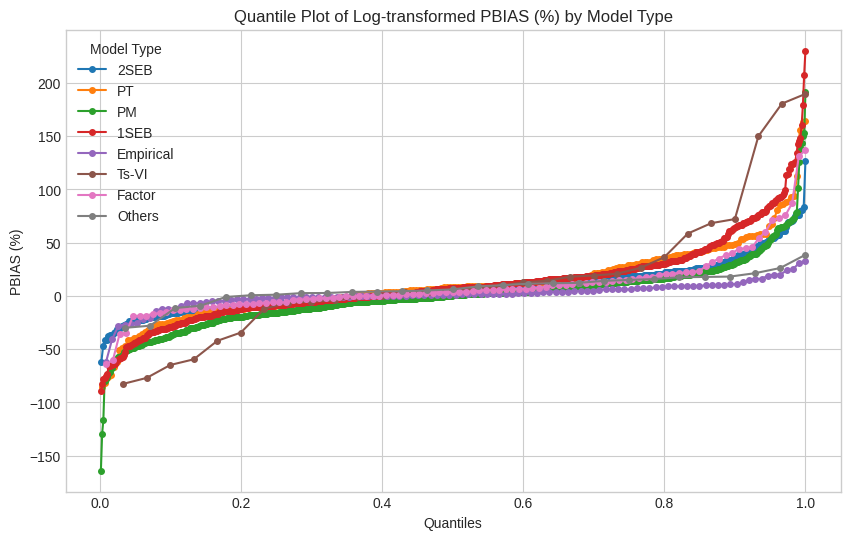

In [168]:
# Using dataframe df_model_types: plot a quantile plot for natural logarithms of the "ModelType" groups of "PBIAS (%)" data in the same graph . don't use altair

import numpy as np
import matplotlib.pyplot as plt

# Calculate the natural logarithm of 'PBIAS (%)'
df_model_types['log_PBIAS'] = np.log(df_model_types['PBIAS (%)'])

# Get the unique model types
model_types = df_model_types['Model Type'].unique()

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Iterate through each model type and plot the quantile plot
for model_type in model_types:
    # Filter the data for the current model type
    data = df_model_types[df_model_types['Model Type'] == model_type]['PBIAS (%)'].dropna()

    # Sort the data
    sorted_data = np.sort(data)

    # Calculate the quantiles
    quantiles = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Plot the quantile plot
    plt.plot(quantiles, sorted_data, marker='o', linestyle='-', label=model_type, markersize=4)

# Add labels and title
plt.xlabel('Quantiles')
plt.ylabel('PBIAS (%)')
plt.title('Quantile Plot of Log-transformed PBIAS (%) by Model Type')
plt.legend(title='Model Type')
plt.grid(True)
plt.show()

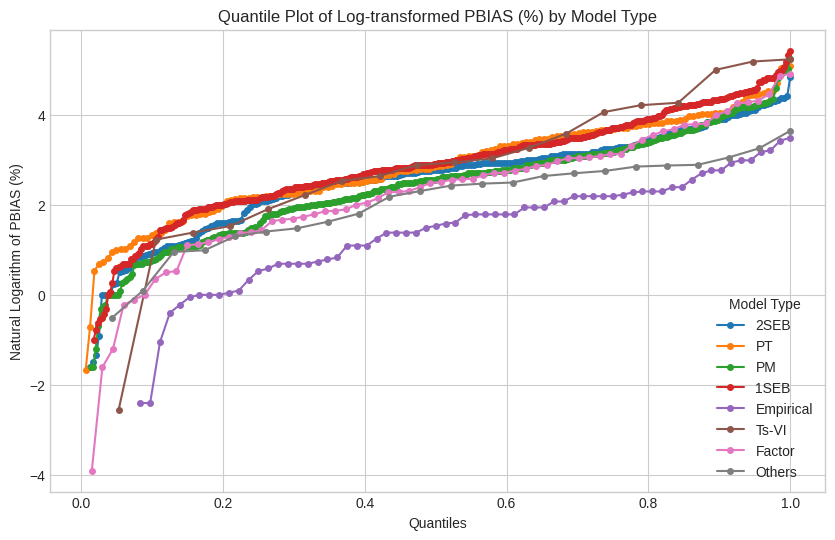

In [169]:
# Using dataframe df_model_types: plot a quantile plot for natural logarithms of the "ModelType" groups of "PBIAS (%)" data in the same graph . don't use altair

import numpy as np
import matplotlib.pyplot as plt

# Calculate the natural logarithm of 'PBIAS (%)'
df_model_types['log_PBIAS'] = np.log(df_model_types['PBIAS (%)'])

# Get the unique model types
model_types = df_model_types['Model Type'].unique()

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Iterate through each model type and plot the quantile plot
for model_type in model_types:
    # Filter the data for the current model type
    data = df_model_types[df_model_types['Model Type'] == model_type]['log_PBIAS'].dropna()

    # Sort the data
    sorted_data = np.sort(data)

    # Calculate the quantiles
    quantiles = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Plot the quantile plot
    plt.plot(quantiles, sorted_data, marker='o', linestyle='-', label=model_type, markersize=4)

# Add labels and title
plt.xlabel('Quantiles')
plt.ylabel('Natural Logarithm of PBIAS (%)')
plt.title('Quantile Plot of Log-transformed PBIAS (%) by Model Type')
plt.legend(title='Model Type')
plt.grid(True)
plt.show()

## Pair-wise difference test

In [170]:

dunn_results = sp.posthoc_dunn(df_, val_col='PBIAS (%)', group_col='Model Type', p_adjust='holm')
dunn_results


,1SEB,2SEB,Empirical,Factor,Others,PM,PT,Ts-VI
1SEB,1.000000e+00,1.000000,0.196119,1.000000,1.000000,9.573664e-07,1.000000,1.0
2SEB,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.177431e-03,1.000000,1.0
Empirical,1.961188e-01,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.125053,1.0
Factor,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.943063e-01,1.000000,1.0
Others,1.000000e+00,1.000000,1.000000,1.000000,1.000000,8.159393e-01,1.000000,1.0
PM,9.573664e-07,0.001177,1.000000,0.194306,0.815939,1.000000e+00,0.000020,1.0
PT,1.000000e+00,1.000000,0.125053,1.000000,1.000000,1.995705e-05,1.000000,1.0
Ts-VI,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.0


In [172]:
# Using dataframe dunn_results: Print string that explain Dunn's test results

# Assuming a significance level of 0.05, print a summary of Dunn's test results
alpha = 0.05

# Iterate through the columns of the dataframe (which represent the pairwise comparisons)
for column in dunn_results.columns:
    # Iterate through the rows (which also represent the pairwise comparisons)
    for index, p_value in dunn_results[column].items():
        # Get the names of the groups being compared
        group1 = index
        group2 = column

        # Only report comparisons where the p-value is not NaN (i.e., a comparison was performed)
        if pd.notna(p_value):
            # Check if the p-value is less than the significance level
            if p_value < alpha:
                # Print a message indicating a statistically significant difference
                print(f"Dunn's test results: There is a statistically significant difference between group {group1} and group {group2} (p = {p_value:.4f})")
            # else:
            #     # Print a message indicating no statistically significant difference
            #     print(f"Dunn's test results: There is no statistically significant difference between group {group1} and group {group2} (p = {p_value:.4f})")

Dunn's test results: There is a statistically significant difference between group PM and group 1SEB (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group PM and group 2SEB (p = 0.0012)
Dunn's test results: There is a statistically significant difference between group 1SEB and group PM (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group 2SEB and group PM (p = 0.0012)
Dunn's test results: There is a statistically significant difference between group PT and group PM (p = 0.0000)
Dunn's test results: There is a statistically significant difference between group PM and group PT (p = 0.0000)


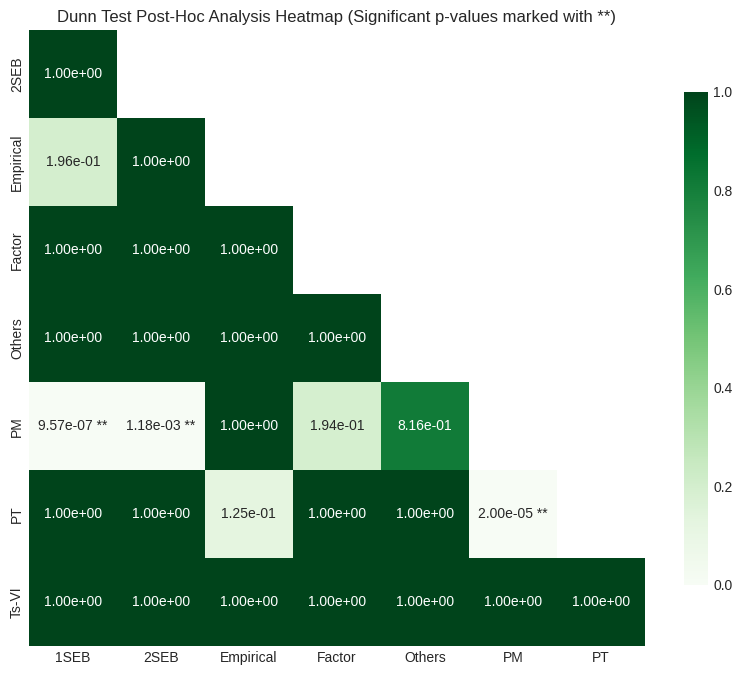

In [223]:
# build an upper‐triangle mask
mask = np.triu(np.ones_like(dunn_results, dtype=bool))

# Create a custom colormap
# Red for p-values < 0.05, shades of green for others
cmap = sns.color_palette("Greens", as_cmap=True)
cmap.set_bad('white') # Set color for masked values

# Create annotations with asterisks for significant values and scientific format
annot_df = dunn_results.copy().astype(str)
for i in range(dunn_results.shape[0]):
    for j in range(dunn_results.shape[1]):
        if pd.notna(dunn_results.iloc[i, j]):
            if dunn_results.iloc[i, j] < 0.05:
                # Format significant p-values in scientific notation with asterisk
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e} **"
            else:
                # Format non-significant p-values in scientific notation
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e}"
        else:
            annot_df.iloc[i, j] = ""

# Slice the DataFrame to remove the first row and last column
dunn_results_sliced = dunn_results.iloc[1:, :-1]
annot_df_sliced = annot_df.iloc[1:, :-1]
mask_sliced = mask[1:, :-1]


plt.figure(figsize=(10, 8)) # Increased figure size for potentially larger cells
sns.heatmap(
    dunn_results_sliced,
    mask=mask_sliced,
    annot=annot_df_sliced, # Use the custom annotated dataframe
    cmap=cmap, # Use the custom colormap
    fmt="", # Use empty format as we are formatting in annot_df
    square=True,
    cbar_kws={"shrink": 0.8},
    vmin=0, vmax=1 # Set value range for colormap
)
plt.title('Dunn Test Post-Hoc Analysis Heatmap (Significant p-values marked with **)')
plt.show()

## Plot distribution and Dunn's test

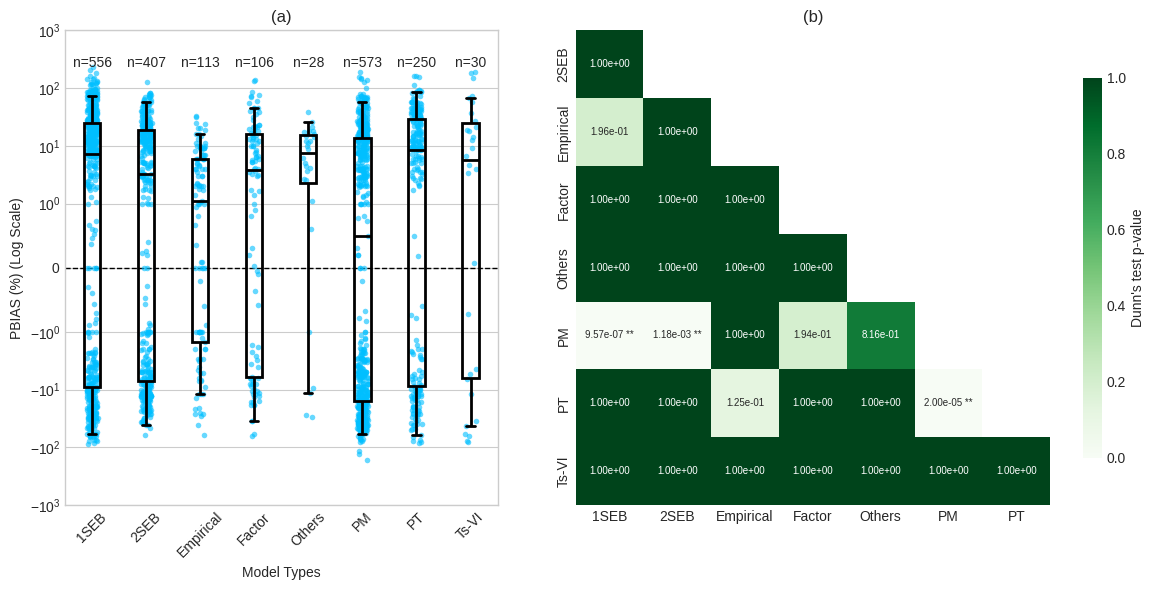

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 3]})

df_ = df_models

# Set up the plot
model_order = ['1SEB', '2SEB', 'Empirical', 'Factor', 'Others', 'PM', 'PT', 'Ts-VI']
# Plot strip plot first (so it's underneath)
sns.stripplot(x='Model Type', y='PBIAS (%)', ax=axes[0],data=df_,
              color='deepskyblue', jitter=True, size=4, alpha=0.6,order=model_order)

# Overlay boxplot with no fill and thicker, brighter outline
sns.boxplot(
    x='Model Type', y='PBIAS (%)', data=df_,ax=axes[0],
    width=0.3, showcaps=True, showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=2, zorder=3),
    whiskerprops=dict(color='black', linewidth=2, zorder=3),
    capprops=dict(color='black', linewidth=2, zorder=3),
    medianprops=dict(color='black', linewidth=2, zorder=3)
)

# Annotate group sizes
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
# Ensure group_counts is in the same order as model_order for correct annotation placement
group_counts = group_counts.set_index('Model Type').loc[model_order].reset_index()


for i, model_type in enumerate(model_order):
    count = group_counts[group_counts['Model Type'] == model_type]['count'].values[0]
    # Adjust text placement slightly if needed based on the log scale
    axes[0].text(i, df_['PBIAS (%)'].max() + 2, f'n={count}', ha='center')


# Labels and title
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1) # Corrected method here
axes[0].set_xlabel('Model Types')
axes[0].set_ylabel('PBIAS (%) (Log Scale)') # Update y-axis label
axes[0].set_yscale('symlog', linthresh=1) # Set y-axis to symmetric log scale to handle negative values
axes[0].set_ylim(-1000,1000)
axes[0].set_title('(a)') # Add title for the first subplot
axes[0].tick_params(axis='x', rotation=45)

#------------------------------------------------------
# build an upper‐triangle mask
mask = np.triu(np.ones_like(dunn_results, dtype=bool))

# Create a custom colormap
# Red for p-values < 0.05, shades of green for others
cmap = sns.color_palette("Greens", as_cmap=True)
cmap.set_bad('white') # Set color for masked values

# Create annotations with asterisks for significant values and scientific format
annot_df = dunn_results.copy().astype(str)
for i in range(dunn_results.shape[0]):
    for j in range(dunn_results.shape[1]):
        if pd.notna(dunn_results.iloc[i, j]):
            if dunn_results.iloc[i, j] < 0.05:
                # Format significant p-values in scientific notation with asterisk
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e} **"
            else:
                # Format non-significant p-values in scientific notation
                annot_df.iloc[i, j] = f"{dunn_results.iloc[i, j]:.2e}"
        else:
            annot_df.iloc[i, j] = ""

# Slice the DataFrame to remove the first row and last column
dunn_results_sliced = dunn_results.iloc[1:, :-1]
annot_df_sliced = annot_df.iloc[1:, :-1]
mask_sliced = mask[1:, :-1]

sns.heatmap(
    dunn_results_sliced,
    mask=mask_sliced,
    annot=annot_df_sliced, # Use the custom annotated dataframe
    annot_kws={"fontsize": 7},
    cmap=cmap, # Use the custom colormap
    fmt="", # Use empty format as we are formatting in annot_df
    square=True,
    cbar_kws={"shrink": 0.8,  "label": "Dunn's test p-value"}, # Added orientation and label
    vmin=0, vmax=1, # Set value range for colormap
    ax=axes[1]
)
axes[1].set_title('(b)') # Add title for the second subplot
plt.tight_layout()
plt.savefig(os.path.join(save_folder,'4_pbias_by_model_type.png'), bbox_inches='tight')
plt.show()

## Ranking model

In [177]:
dunn_results

,1SEB,2SEB,Empirical,Factor,Others,PM,PT,Ts-VI
1SEB,1.000000e+00,1.000000,0.196119,1.000000,1.000000,9.573664e-07,1.000000,1.0
2SEB,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.177431e-03,1.000000,1.0
Empirical,1.961188e-01,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.125053,1.0
Factor,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.943063e-01,1.000000,1.0
Others,1.000000e+00,1.000000,1.000000,1.000000,1.000000,8.159393e-01,1.000000,1.0
PM,9.573664e-07,0.001177,1.000000,0.194306,0.815939,1.000000e+00,0.000020,1.0
PT,1.000000e+00,1.000000,0.125053,1.000000,1.000000,1.995705e-05,1.000000,1.0
Ts-VI,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.0


In [180]:
def get_statistical_tiers(pvals_df, alpha=0.05):
    """
    Assigns each group to a single tier (A, B, C, ...) based on pairwise significance.
    Groups that are not significantly different are placed in the same tier.
    """
    groups = list(pvals_df.columns)
    tiers = {}
    assigned = set()
    sorted_groups = pvals_df.replace(np.nan, 1.0).mean().sort_values().index.tolist()
    tier_labels = iter(string.ascii_uppercase)

    for group in sorted_groups:
        if group in assigned:
            continue

        current_tier = next(tier_labels)
        similar = {group}

        for other in sorted_groups:
            if other == group or other in assigned:
                continue
            pval = pvals_df.loc[group, other]
            if pd.isna(pval) or pval >= alpha:
                similar.add(other)

        for g in similar:
            tiers[g] = current_tier
            assigned.add(g)

    return pd.DataFrame({'Model Type': list(tiers.keys()), 'Tier': list(tiers.values())})

dunn_results = sp.posthoc_dunn(df_, val_col='PBIAS (%)', group_col='Model Type', p_adjust='holm')

tier_df = get_statistical_tiers(dunn_results)
tier_df

,Model Type,Tier
0,Ts-VI,A
1,PM,A
2,Empirical,A
3,Factor,A
4,Others,A
5,PT,B
6,2SEB,B
7,1SEB,B


# Model type vs Land cover type

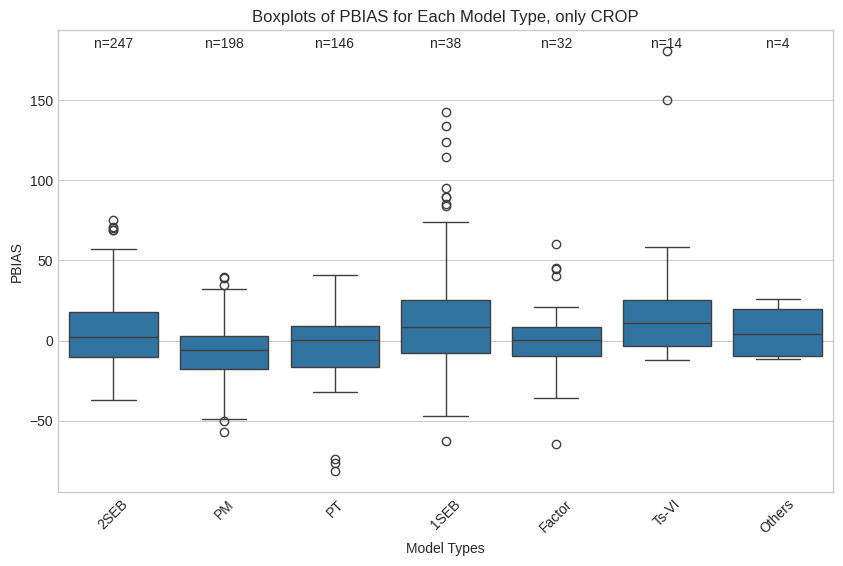

In [263]:
df_ = df_[df_['IGBPQGIS'] == 'CRO']
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model Type', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['Model Type'].value_counts().reset_index()
group_counts.columns = ['Model Type', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('Model Types')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each Model Type, only CROP')
plt.xticks(rotation=45)
plt.show()

In [265]:
# Perform one-way ANOVA
anova_result = f_oneway(df_[df_['Model Type'] == '2SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == '1SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PT']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PM']['PBIAS (%)'],
                        # df_[df_['Model Type'] == 'Empirical']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Factor']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Others']['PBIAS (%)'],
                        )

# Print the ANOVA result
print("ANOVA F-Statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("There is a significant difference between the groups (p < 0.05)")
else:
    print("There is no significant difference between the groups (p >= 0.05)")

ANOVA F-Statistic: 11.186760804226399
ANOVA p-value: 2.2955494000224883e-10
There is a significant difference between the groups (p < 0.05)


In [266]:
# Perform Kruskal-Wallis H-test
kruskal_result = kruskal(df_[df_['Model Type'] == '2SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == '1SEB']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PT']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'PM']['PBIAS (%)'],
                        # df_[df_['Model Type'] == 'Empirical']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Factor']['PBIAS (%)'],
                        df_[df_['Model Type'] == 'Others']['PBIAS (%)'])


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

Kruskal-Wallis H-Statistic: 46.90122800308256
Kruskal-Wallis p-value: 5.951069899170721e-09
There is a significant difference in the distribution of the groups (p < 0.05)


In [267]:
# prompt: first, filter only rows with "Number of sites (N)" = 1. Then plot the frequency of 'Model Type' versus 'IGBPQGIS'

# Filter rows where "Number of sites (N)" is 1
df_filtered = df[df['Number of sites (N)'] == 1]

# Create a cross-tabulation of 'Model Type' and 'IGBPQGIS'
cross_tab = pd.crosstab(df_filtered['Model Type'], df_filtered['IGBPQGIS'])

# Plot the frequency of 'Model Type' versus 'IGBPQGIS'
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Frequency of Model Type vs. IGBPQGIS (for N=1)')
plt.xlabel('IGBPQGIS')
plt.ylabel('Model Type')
plt.show()

KeyError: 'Number of sites (N)'

# Land cover type


```
BSV
CRO
CSH
CVM
DBF
DNF
EBF
ENF
GRA
MF
OSH
SAV
SNO
URB
WAT
WET
WSA
```


In [ ]:
# Define a list of values to filter
values_to_filter = ['BSV',
'CRO',
'CSH',
'CVM',
'DBF',
'DNF',
'EBF',
'ENF',
'GRA',
'MF',
'OSH',
'SAV',
'SNO',
'URB',
'WAT',
'WET',
'WSA'] # valid Model types

# Filter rows with values in the "model types" column
df_models = filtered_df[filtered_df['IGBP class'].isin(values_to_filter)]

In [ ]:
df_ = df_models[df_models['Number of sites (N)'] == 1]
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='IGBP class', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['IGBP class'].value_counts().reset_index()
group_counts.columns = ['IGBP class', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('IGBP class')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each IGBP class')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_ = df_models[df_models['Number of sites (N)'] == 1]
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
sns.boxplot(x='IGBPQGIS', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['IGBPQGIS'].value_counts().reset_index()
group_counts.columns = ['IGBPQGIS', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['PBIAS (%)'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('IGBPQGIS')
plt.ylabel('PBIAS')
plt.title('Boxplots of PBIAS for Each IGBP class')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Perform Kruskal-Wallis H-test
kruskal_result = kruskal(df_[df_['IGBPQGIS'] == 'CRO']['PBIAS (%)'],
                        df_[df_['IGBPQGIS'] == 'WSA']['PBIAS (%)'],
                        df_[df_['IGBPQGIS'] == 'CSH']['PBIAS (%)'],
                        df_[df_['IGBPQGIS'] == 'OSH']['PBIAS (%)'])


# Print the Kruskal-Wallis test result
print("Kruskal-Wallis H-Statistic:", kruskal_result.statistic)
print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

# Check for significance
if kruskal_result.pvalue < 0.05:
    print("There is a significant difference in the distribution of the groups (p < 0.05)")
else:
    print("There is no significant difference in the distribution of the groups (p >= 0.05)")

# Products vs Models

/tmp/ipython-input-61-3798348002.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




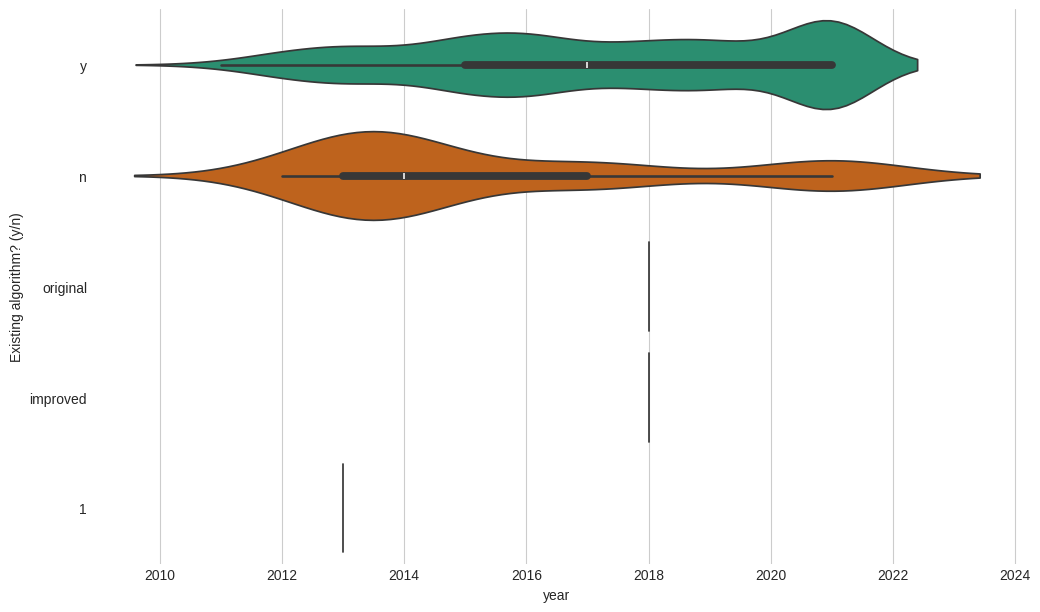

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Existing algorithm? (y/n)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='year', y='Existing algorithm? (y/n)', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
df_ = filtered_df
# Plot boxplots of PBIAS for each model type
plt.figure(figsize=(10, 6))
boxplot=sns.boxplot(x='Primary/Secondary data', y='PBIAS (%)', data=df_)

# Annotate the plot with the count of data points for each group
group_counts = df_['Primary/Secondary data'].value_counts().reset_index()
group_counts.columns = ['Primary/Secondary data', 'count']
for index, row in group_counts.iterrows():
    plt.text(index, df_['Primary/Secondary data'].max() + 2, f'n={row["count"]}', ha='center')

plt.xlabel('Primary/Secondary data')
plt.ylabel('PBIAS')
plt.title('Model validation (Primary data) vs Product evaluation (Secondary data)')
plt.xticks(rotation=45)
boxplot.set_xticklabels(['Primary data','Secondary data'])
plt.show()

In [ ]:
df_['PBIAS (%)'] = pd.to_numeric(df_['PBIAS (%)'], errors='coerce')
# Separate data into "Primary" and "Secondary" groups
primary_data = df_[df_['Primary/Secondary data'] == 1]['PBIAS (%)']
secondary_data = df_[df_['Primary/Secondary data'] == 2]['PBIAS (%)']

# Perform independent t-test
t_statistic, p_value = ttest_ind(primary_data, secondary_data)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Check for significance
if p_value < 0.05:
    print("The difference between the groups is statistically significant (p < 0.05)")
else:
    print("The difference between the groups is not statistically significant (p >= 0.05)")

In [ ]:
df_test = df_[['Primary/Secondary data','PBIAS (%)']]
df_test

In [ ]:
# prompt: Using dataframe df_test: test normal distribution 'PBIAS (%)' for each group in 'Primary/Secondary data'. print the explanation of results

import scipy.stats as stats

# Group the data by 'Primary/Secondary data'
grouped_data = df_test.groupby('Primary/Secondary data')

# Iterate over each group
for name, group in grouped_data:
    # Perform the Shapiro-Wilk test for normality on the 'PBIAS (%)' column
    statistic, p_value = stats.shapiro(group['PBIAS (%)'])

    # Print the results for each group
    print(f"Results for group: {name}")
    print(f"Shapiro-Wilk Test Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interpret the results
    alpha = 0.05
    if p_value > alpha:
        print(f"For group {name}, the data appears to be normally distributed (p > {alpha}).")
    else:
        print(f"For group {name}, the data does not appear to be normally distributed (p <= {alpha}).")
    print("-" * 30)


In [ ]:
# prompt: Using dataframe df_test: compare 'PBIAS (%)' for each group in 'Primary/Secondary data', using  Mann-Whitney U Test (also known as Wilcoxon Rank-Sum Test).
# print the explanation of the results.

from scipy.stats import mannwhitneyu
# Separate the data into two groups based on the 'Primary/Secondary data' column
group1 = df_test[df_test['Primary/Secondary data'] == 1]['PBIAS (%)']
group2 = df_test[df_test['Primary/Secondary data'] == 2]['PBIAS (%)']
# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(group1, group2)
# Print the results and explanation
print(f"Mann-Whitney U Statistic: {statistic}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The p-value is less than 0.05, indicating a statistically significant difference in 'PBIAS (%)' between the two groups.")
else:
    print("The p-value is greater than or equal to 0.05, indicating no statistically significant difference in 'PBIAS (%)' between the two groups.")

In [ ]:
# prompt: Using dataframe df_test: calculate descriptive statistics of 'PBIAS (%)' for each group in 'Primary/Secondary data'.

df_test.groupby('Primary/Secondary data')['PBIAS (%)'].describe()

/tmp/ipython-input-62-4222618068.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




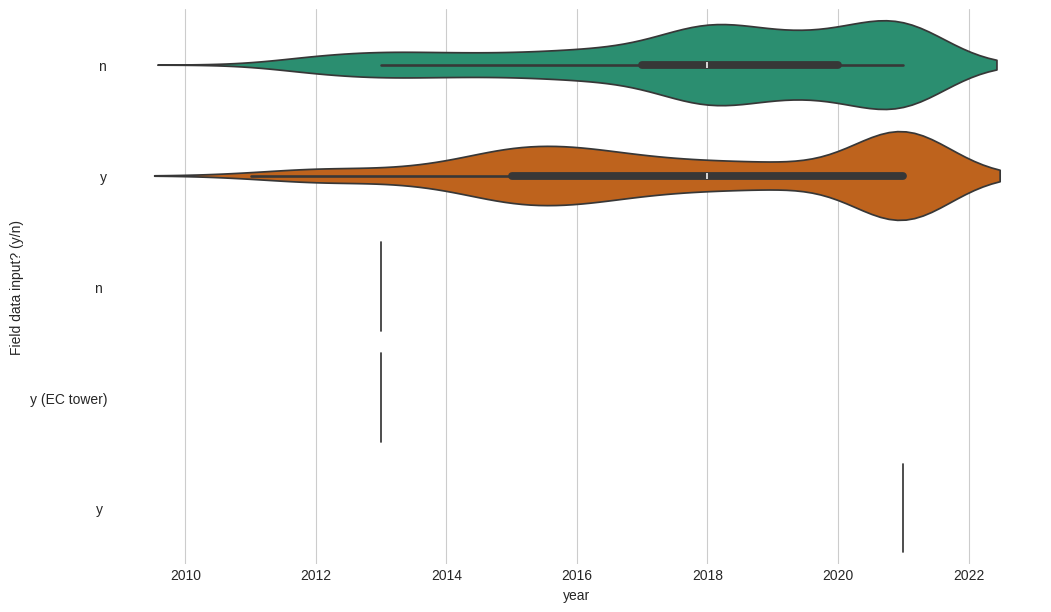

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Field data input? (y/n)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='year', y='Field data input? (y/n)', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

The Shapiro-Wilk test is used to check if a sample comes from a normally distributed population.
The null hypothesis (H0) is that the data is normally distributed.
The alternative hypothesis (H1) is that the data is not normally distributed.
We use a significance level (alpha) of 0.05.
If the p-value is greater than alpha, we fail to reject the null hypothesis, suggesting the data is likely normally distributed.
If the p-value is less than or equal to alpha, we reject the null hypothesis, suggesting the data is likely not normally distributed.
The results above show the test statistic and p-value for the 'PBIAS (%)' column within each group of 'Primary/Secondary data'.
Based on the p-value for each group compared to alpha, we can determine whether the 'PBIAS (%)' data within that specific group follows a normal distribution.